In [2]:
import Demo
import Data.Massiv.Array as A
import Data.Massiv.Array.IO as A
import Graphics.Color.Space

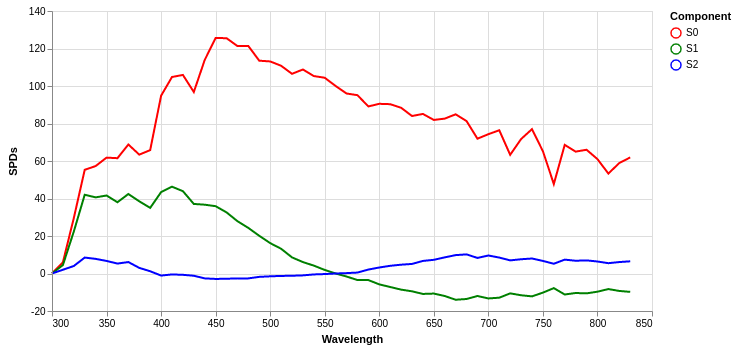

In [4]:
import Graphics.Color.Illuminant.CIE1931 as CIE1931
import Graphics.Vega.VegaLite as VL hiding (Color)
import IHaskell.Display.Hvega

:set -XOverloadedStrings

plotSpd = toVegaLite
  [ description "CIE 1931 Spectral Power Distributions"
  , background "white"
  , cie1931spd
  , transform . foldAs ["S0", "S1", "S2"] "Component" "SPDs"$ []
  , mark Line []
  , encoding 
    . position VL.X [PName "Wavelength", PmType Quantitative]
    . position VL.Y [PName "SPDs", PmType Quantitative]
    . color [ MName "Component", MmType Nominal , MScale [SDomain (DStrings ["S0", "S1", "S2"]), SRange (RStrings ["Red", "Green", "Blue"])] ]
    $ []
  , height 300
  , width 600
  ]
  where
    cie1931spd = dataFromColumns []
               . dataColumn "Wavelength" (Numbers [w | (w, _) <- CIE1931.spectralPowerDistributions])
               . dataColumn "S0" (Numbers [s0 | (_, V3 s0 _ _) <- CIE1931.spectralPowerDistributions])
               . dataColumn "S1" (Numbers [s1 | (_, V3 _ s1 _) <- CIE1931.spectralPowerDistributions])
               . dataColumn "S2" (Numbers [s3 | (_, V3 _ _ s3) <- CIE1931.spectralPowerDistributions])
               $ []
vlShow plotSpd

In [5]:
daylightChromaticityY :: RealFloat a => a -> a
daylightChromaticityY x = 2.87 * x - 3 * x ^ (2 :: Int) - 0.275


daylightChromaticityX_4000to7000K :: Fractional a => a -> a
daylightChromaticityX_4000to7000K t =
    0.244063
  + 0.09911 * 10 ^ (3 :: Int) / t
  + 2.96780 * 10 ^ (6 :: Int) / (t ^ (2 :: Int))
  - 4.60700 * 10 ^ (9 :: Int) / (t ^ (3 :: Int))

daylightChromaticityX_7000to25000K :: Fractional a => a -> a
daylightChromaticityX_7000to25000K t =
    0.237040
  + 0.24748 * 10 ^ (3 :: Int) / t
  + 1.90180 * 10 ^ (6 :: Int) / (t ^ (2 :: Int))
  - 2.00640 * 10 ^ (9 :: Int) / (t ^ (3 :: Int))


daylightChromaticity :: (Show e, RealFloat e) => e -> V2 e
daylightChromaticity t = V2 x y
  where
    x
      | 4000 <= t && t < 7000 = daylightChromaticityX_4000to7000K t
      | 7000 <= t && t <= 25000 = daylightChromaticityX_7000to25000K t
      | otherwise = error $ "Invalid temperature: " ++ show t
    y = daylightChromaticityY x

plotSpd = toVegaLite
  [ description "CIE 1931 Planckian locus"
  , background "white"
  , locus
  , mark Line []
  , encoding 
    . position VL.X [PName "x", PmType Quantitative]
    . position VL.Y [PName "y", PmType Quantitative, PScale [SDomain (DNumbers [0.25, 0.4])]]
    $ []
  , height 400
  , width 500
  ]
  where
    temperatures = [4000, 4050 .. 25000] :: [Double]
    locusData = fmap daylightChromaticity temperatures
    locus = dataFromColumns []
          . dataColumn "x" (Numbers [x | V2 x _ <- locusData])
          . dataColumn "y" (Numbers [y | V2 _ y <- locusData])
          $ []
--vlShow plotSpd
daylightChromaticity 6504

[ 0.312714056883, 0.329119099137 ]

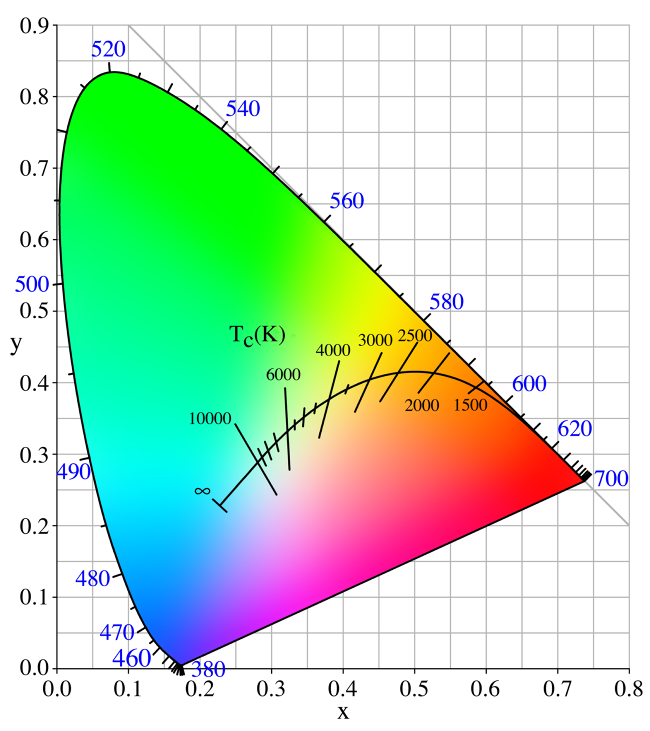

In [58]:
import qualified Graphics.Color.Model as CM
g <- readImage "Gamut.png" :: IO (A.Image S CM.RGB Word8)
display g

In [59]:
:set -XDataKinds

d65 = whitePoint :: WhitePoint 'D65 Float

print d65

WhitePoint (Chromaticity <CIExyY CIE1931 'D65:( 0.312720, 0.329030)>)

In [60]:
:set -XDataKinds
print (colorTemperature :: CCT 'D65)

CCT {unCCT = 6503.616133518777}

In [61]:
daylightChromaticity (unCCT (colorTemperature :: CCT 'D65))

[ 0.312720273260, 0.329125276333 ]

In [62]:
import Data.Coerce
xyD65 = coerce (daylightChromaticity (unCCT (colorTemperature :: CCT 'D65))) :: Color (CIExyY 'D65) Double
print xyD65
print (whitePoint :: WhitePoint 'D65 Float)

<CIExyY CIE1931 'D65:( 0.312720273260, 0.329125276333)>

WhitePoint (Chromaticity <CIExyY CIE1931 'D65:( 0.312720, 0.329030)>)

In [63]:
toColorXYZ xy

<XYZ CIE1931 'D65:( 0.950155748426, 1.000000000000, 1.088200986557)>

In [64]:
import Graphics.Color.Space.RGB.Derived.SRGB as Derived
fromColorXYZ (toColorXYZ xy) :: Color (Derived.SRGB 'D65) Float

<SRGB CIE1931 'D65:( 0.999742, 1.000106, 0.999712)>

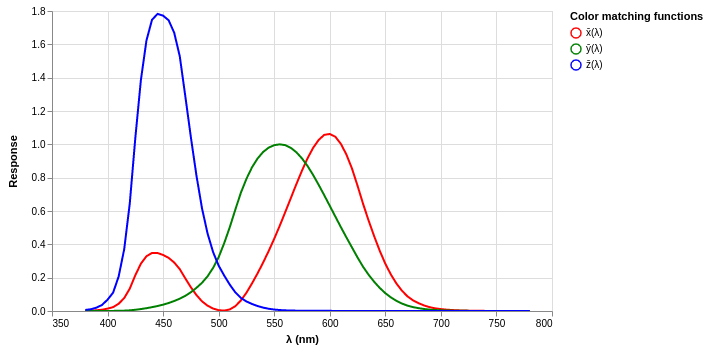

In [9]:
plotcmf = toVegaLite
  [ description "CIE 1931 Color Matching Functions"
  , background "white"
  , cie1931cmf
  , transform . foldAs ["x̄(λ)", "ȳ(λ)", "z̄(λ)"] "Color matching functions" "Response"$ []
  , mark Line []
  , encoding 
    . position VL.X [PName "λ (nm)", PmType Quantitative]
    . position VL.Y [PName "Response", PmType Quantitative]
    . color [ MName "Color matching functions", MmType Nominal , MScale [SDomain (DStrings ["x̄(λ)", "ȳ(λ)", "z̄(λ)"]), SRange (RStrings ["Red", "Green", "Blue"])] ]
    $ []
  , height 300
  , width 500
  ]
  where
    cie1931cmf = dataFromColumns []
               . dataColumn "λ (nm)" (Numbers [w | (w, _, _) <- CIE1931.colorMatchingFunctions])
               . dataColumn "x̄(λ)" (Numbers [s0 | (_, V3 s0 _ _, _) <- CIE1931.colorMatchingFunctions])
               . dataColumn "ȳ(λ)" (Numbers [s1 | (_, V3 _ s1 _, _) <- CIE1931.colorMatchingFunctions])
               . dataColumn "z̄(λ)" (Numbers [s3 | (_, V3 _ _ s3, _) <- CIE1931.colorMatchingFunctions])
               $ []
vlShow plotcmf
